# Fastai SageMaker Demo

The following notebook demonstrates a working implementation of the Fastai library with Amazon SageMaker.

## Prequisites and Preprocessing
### Permissions and environment variables
Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

bucket='sagemaker-mcclean-eu-west-1' # customize to your bucket
ecr_repo_name = 'fastai-conv-net' # customize to the name of your ECR repo

data_prefix='data/dogscats'

client = boto3.client("sts")
account_id = client.get_caller_identity()["Account"]
region_name = boto3.Session().region_name
print('AWS Account ID: {}'.format(account_id))
print('Region: {}'.format(region_name))

training_image = '{}.dkr.ecr.{}.amazonaws.com/{}:latest'.format(account_id, region_name, ecr_repo_name)

print('Docker image for training is: {}'.format(training_image))
print('IAM role for SageMaker: {}'.format(role))

AWS Account ID: 934676248949
Region: eu-west-1
Docker image for training is: 934676248949.dkr.ecr.eu-west-1.amazonaws.com/fastai-conv-net:latest
IAM role for SageMaker: arn:aws:iam::934676248949:role/service-role/AmazonSageMaker-ExecutionRole-20171203T194740
CPU times: user 260 ms, sys: 124 ms, total: 384 ms
Wall time: 899 ms


## Hyperparameters
Set the hyperparameters for the training of the model.

In [2]:
# The algorithm supports multiple parameters
# we need to specify the input image size
image_size = 224
# number of epochs
epochs = 3
# learning rate
learning_rate = 0.01

## Build the Docker image
Build the Docker image and upload to ECR to be used for both training and inference of our fast.ai model.

# Training
Run the training using Amazon sagemaker CreateTrainingJob API

In [7]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'sagemaker-fastai-dogscats'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_size": str(image_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "training",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/{}/train/'.format(bucket, data_prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "image/jpeg",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/{}/valid/'.format(bucket, data_prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "image/jpeg",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-fastai-dogscats-2018-02-21-17-37-25

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-mcclean-eu-west-1/data/dogscats/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.96 ms


In [8]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


## Create Model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [9]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

model_name="fastai-conv-net-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

fastai-conv-net-model
s3://sagemaker-mcclean-eu-west-1/sagemaker-fastai-dogscats/output/sagemaker-fastai-dogscats-2018-02-21-17-37-25/output/model.tar.gz
arn:aws:sagemaker:eu-west-1:934676248949:model/fastai-conv-net-model
CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 1.29 s


## Create the Endpoint Configuration

Now we can create the Endpoint configuration to deploy the model for inference.

In [10]:
from time import gmtime, strftime

endpoint_config_name = 'fastai-convnet-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)
create_endpoint_config_response = sagemaker.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.p2.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

fastai-convnet-endpoint-config-2018-02-22-14-21-04
Endpoint Config Arn: arn:aws:sagemaker:eu-west-1:934676248949:endpoint-config/fastai-convnet-endpoint-config-2018-02-22-14-21-04


## Create the Endpoint

Now we can create the endpoint to do the model inference.

In [20]:
%%time
import time

endpoint_name = 'fastai-convnet-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sagemaker.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)
print(create_endpoint_response['EndpointArn'])

resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

fastai-convnet-endpoint-2018-02-23-10-21-29
arn:aws:sagemaker:eu-west-1:934676248949:endpoint/fastai-convnet-endpoint-2018-02-23-10-21-29
Status: Creating
Arn: arn:aws:sagemaker:eu-west-1:934676248949:endpoint/fastai-convnet-endpoint-2018-02-23-10-21-29
Create endpoint ended with status: InService
CPU times: user 104 ms, sys: 8 ms, total: 112 ms
Wall time: 11min 33s


## Randomly select test image
Randomly select an image from the test folder to submit to the SageMaker prediction endpoint.

data/dogscats/test1/11860.jpg


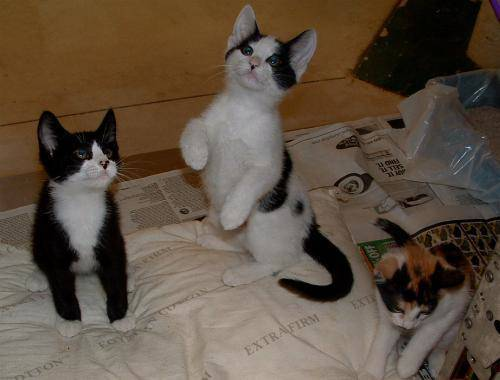

In [33]:
import os, random
dir_name = 'data/dogscats/test1/'
file_name = dir_name + random.choice(os.listdir(dir_name)) #change dir name to whatever
print(file_name)
#file_name = 'data/dogscats/test1/9969.jpg'
# test image
from IPython.display import Image
Image(file_name)

## Call Endpoint
Call the endpoint with some test data.

In [34]:
%%time
import time
import json

runtime = boto3.Session().client('runtime.sagemaker')

with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
print(json.loads(result))

{'result': {'class': 'cats', 'confidence': 0.00020511190814431757}}
CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 221 ms
